### Feature engineering

We are going to use:
- fear data
- medium in the last weeks


In [1]:
import warnings
warnings.filterwarnings("ignore")
from mlflow import MlflowClient, set_tracking_uri
import mlflow
from typing import Tuple
from tqdm import tqdm
import pandas as pd
from datetime import datetime, timedelta
import mysql.connector
import pyarrow
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import argparse
import os
from dateutil.relativedelta import relativedelta
import seaborn as sns

In [2]:
# FUNCTIONS:

def get_cutoff_indices(
    data: pd.DataFrame,
    n_features: int, 
    step_size:int
) -> list:
    
    stop_position = len(data) - 1
    
    subseq_first_idex = 0
    subseq_mid_idx = n_features
    subseq_last_idx = n_features + 1
    indices = []
    
    while subseq_last_idx <= stop_position:
        indices.append((subseq_first_idex, subseq_mid_idx, subseq_last_idx))
        
        subseq_first_idex += step_size
        subseq_mid_idx += step_size
        subseq_last_idx += step_size
        
    return indices




def transform_ts_data_into_features_and_target(
    ts_data: pd.DataFrame,
    input_seq_len: int,
    step_size: int
) -> pd.DataFrame:
    """
    Slices and transposes data from time-series format into a (features, target)
    format that we can use to train Supervised ML models
    """
    assert set(ts_data.columns) == {'datetime', 'Open', 'Exchange'}

    exchanges = ts_data['Exchange'].unique()
    #print(exchanges)
    features = pd.DataFrame()
    targets = pd.DataFrame()
    
    for exchange in tqdm(exchanges):
        
        # keep only ts data for this `location_id`
        ts_data_one_exchange = ts_data.loc[
            ts_data.Exchange == exchange, 
            ['datetime', 'Open']
        ]

        # pre-compute cutoff indices to split dataframe rows
        indices = get_cutoff_indices(
            ts_data_one_exchange,
            input_seq_len,
            step_size
        )

        # slice and transpose data into numpy arrays for features and targets
        n_examples = len(indices)
        x = np.ndarray(shape=(n_examples, input_seq_len), dtype=np.float32)
        y = np.ndarray(shape=(n_examples), dtype=np.float32)
        hours = []
        
        for i, idx in enumerate(indices):
            x[i, :] = ts_data_one_exchange.iloc[idx[0]:idx[1]]['Open'].values
            y[i] = ts_data_one_exchange.iloc[idx[1]:idx[2]]['Open'].values
            hours.append(ts_data_one_exchange.iloc[idx[1]]['datetime'])


        # numpy -> pandas
        features_one_exchange = pd.DataFrame(
            x,
            columns=[f'open_previous_{i+1}_day' for i in reversed(range(input_seq_len))]
        )
        features_one_exchange['datetime'] = hours
        features_one_exchange['exchange'] = exchange

        # numpy -> pandas
        targets_one_exchange = pd.DataFrame(y, columns=[f'target_open_next_day'])

        # concatenate results
        features = pd.concat([features, features_one_exchange])
        targets = pd.concat([targets, targets_one_exchange])

    features.reset_index(inplace=True, drop=True)
    targets.reset_index(inplace=True, drop=True)

    return features, targets['target_open_next_day']


def train_test_split(
    df: pd.DataFrame,
    cutoff_date: datetime,
    target_column_name: str,
    ) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    """
    train_data = df[df.datetime < cutoff_date].reset_index(drop=True)
    test_data = df[df.datetime >= cutoff_date].reset_index(drop=True)

    X_train = train_data.drop(columns=[target_column_name])
    y_train = train_data[target_column_name]
    X_test = test_data.drop(columns=[target_column_name])
    y_test = test_data[target_column_name]

    return X_train, y_train, X_test, y_test


def metrics_scikit_learn(y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return mse, rmse, mae, r2



In [3]:
exchange = 'BTC-USD'

connection = mysql.connector.connect(
        user = 'root',
        password = 'root',
        host = 'localhost',
        port = 3306,
        database = 'Historical_Data'
    )
print("MySQL DB Connected")
    
cursor = connection.cursor()
cursor.execute(f"SELECT * FROM FT_DAILY_DATA WHERE Exchange = '{exchange}'")

results = cursor.fetchall()
columns = [column[0] for column in cursor.description]

df_original = pd.DataFrame(results, columns=columns)
df = df_original[['id_date', 'Open','Exchange']]
df['datetime'] = pd.to_datetime(df['id_date'], format='%Y%m%d')
#df = df[['id_date', 'Open', 'Exchange']]


df


MySQL DB Connected


,id_date,Open,Exchange,datetime
0,20140917,466,BTC-USD,2014-09-17
1,20140918,457,BTC-USD,2014-09-18
2,20140919,424,BTC-USD,2014-09-19
3,20140920,395,BTC-USD,2014-09-20
4,20140921,408,BTC-USD,2014-09-21
...,...,...,...,...
3578,20240704,60147,BTC-USD,2024-07-04
3579,20240705,57023,BTC-USD,2024-07-05
3580,20240706,56659,BTC-USD,2024-07-06
3581,20240707,58239,BTC-USD,2024-07-07


In [15]:
exchange = 'BTC-USD'

connection = mysql.connector.connect(
        user = 'root',
        password = 'root',
        host = 'localhost',
        port = 3306,
        database = 'Historical_Data'
    )
print("MySQL DB Connected")
    
cursor = connection.cursor()
cursor.execute(f"SELECT * FROM FT_FEAR_DATA")

results = cursor.fetchall()
columns = [column[0] for column in cursor.description]

df_fear = pd.DataFrame(results, columns=columns)
df_fear


MySQL DB Connected


,Value,value_classification,id_date
0,27,Fear,20240709
1,28,Fear,20240708
2,29,Fear,20240707
3,26,Fear,20240706
4,29,Fear,20240705
...,...,...,...
2343,11,Extreme Fear,20180205
2344,24,Extreme Fear,20180204
2345,40,Fear,20180203
2346,15,Extreme Fear,20180202


In [34]:
merged_df = pd.merge(df, df_fear, on='id_date', how='left')
#merged_df = merged_df[merged_df['Value'] ]
merged_df = merged_df.dropna()
merged_df = merged_df[['Open','Value', 'value_classification']]

merged_df.rename(columns={'Value': 'Fear', 'Open': 'Price'}, inplace=True)
merged_df_correlation = merged_df[['Price','Fear']]

merged_df

,Price,Fear,value_classification
1233,10237,30.0,Fear
1234,9142,15.0,Extreme Fear
1235,8852,40.0,Fear
1236,9176,24.0,Extreme Fear
1237,8271,11.0,Extreme Fear
...,...,...,...
3578,60147,44.0,Fear
3579,57023,29.0,Fear
3580,56659,26.0,Fear
3581,58239,29.0,Fear


#### Correlation: Pearson

In [18]:
# Matriz de correlación
# ==============================================================================
corr_matrix = merged_df_correlation.corr(method='pearson')
corr_matrix

,Price,Fear
Price,1.000000,0.394121
Fear,0.394121,1.000000


In [19]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy.
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
1,Price,Fear,0.394121,0.394121
2,Fear,Price,0.394121,0.394121


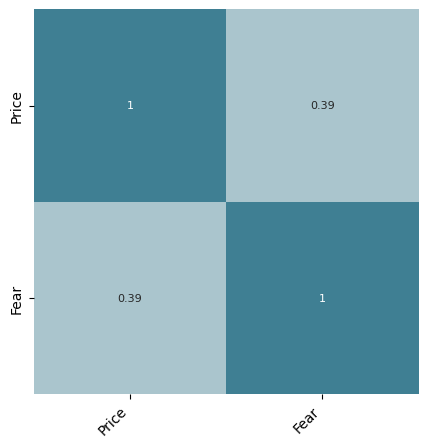

In [20]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

#### Scatter plot

In [35]:
merged_df['value_classification'].unique()

array(['Fear', 'Extreme Fear', 'Neutral', 'Greed', 'Extreme Greed'],
      dtype=object)

In [36]:
# Create a mapping from value_classification to integers from 1 to 5
unique_classes = merged_df.value_classification.unique()
class_mapping = {cls: idx+1 for idx, cls in enumerate(unique_classes)}
print("Class mapping:", class_mapping)

# Map the value_classification to integers
merged_df['class_numeric'] = merged_df.value_classification.map(class_mapping)

Class mapping: {'Fear': 1, 'Extreme Fear': 2, 'Neutral': 3, 'Greed': 4, 'Extreme Greed': 5}


In [37]:
merged_df

,Price,Fear,value_classification,class_numeric
1233,10237,30.0,Fear,1
1234,9142,15.0,Extreme Fear,2
1235,8852,40.0,Fear,1
1236,9176,24.0,Extreme Fear,2
1237,8271,11.0,Extreme Fear,2
...,...,...,...,...
3578,60147,44.0,Fear,1
3579,57023,29.0,Fear,1
3580,56659,26.0,Fear,1
3581,58239,29.0,Fear,1


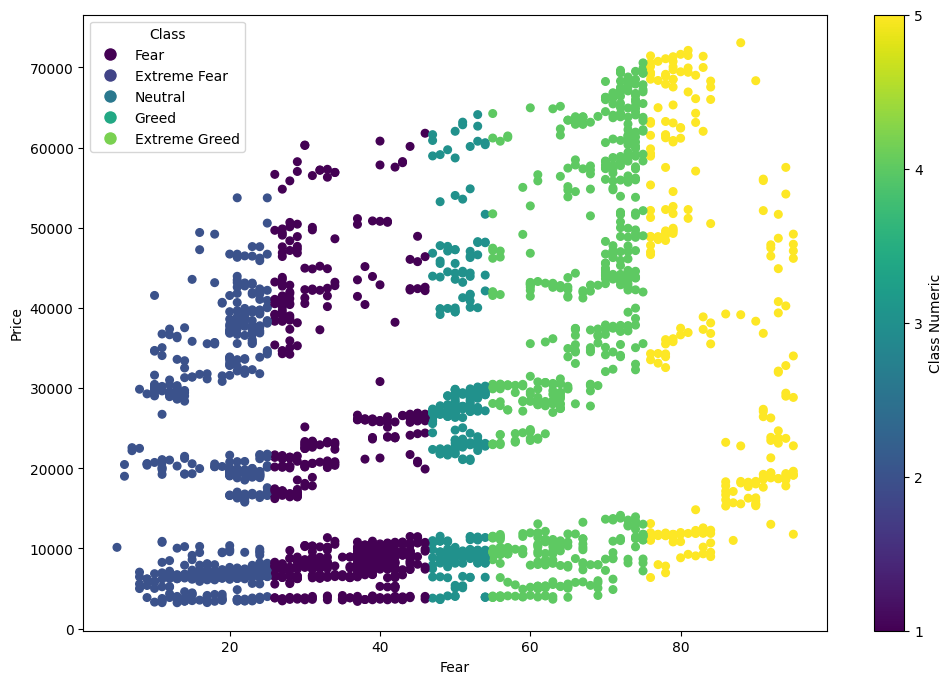

In [55]:
# Create a larger figure
plt.figure(figsize=(12, 8))

scatter = plt.scatter(merged_df.Fear,
            merged_df.Price,
            c = merged_df.class_numeric,
            s = 30,
            cmap = 'viridis')


# Create a legend for the classes
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.viridis(i / len(unique_classes)), markersize=10, label=cls) 
                   for i, cls in enumerate(unique_classes)]

plt.legend(handles=legend_elements, title='Class')


plt.xlabel('Fear')
plt.ylabel('Price')
plt.colorbar(scatter, ticks=range(1, len(unique_classes) + 1), label='Class Numeric')
#plt.legend(merged_df.class_numeric)
plt.show();